In [1]:
import pandas as pd

In [4]:
df = pd.read_csv("data/finalized_data_of_climate_change.csv")

In [5]:
df = df.drop(columns=['index','Unnamed: 0'])
df

,tweetid,stance,sent,tweet_text,cleaned_text,topic_number,topic_name
0,921191642844954624,believer,positive,@FriendsOScience @craigthomler @12zodiac_signs...,excellent video climate change global warm cli...,35,"['video', 'film', '24', 'undefined', 'watch', ..."
1,1422548442665177089,deny,neutral,@GretaThunberg Tweeting &amp; travelling to pa...,tweet travel paid public relation event do not...,-1,"['not', 'energy', 'number', 'get', 'make', 'cl..."
2,953945068502593536,believer,neutral,#THERMOMETER IN #WORLD’S #COLDEST VILLAGE BREA...,thermometer world coldest village break temper...,-1,"['not', 'energy', 'number', 'get', 'make', 'cl..."
3,1435016842326708224,deny,positive,#global #canadanews #globalwarming #climatecha...,global canada news global warm climate change ...,421,"['poli', 'kp', 'oli', 'kleptomania', 'alberta'..."
4,1425192287177527304,believer,neutral,#ClimateActionNow \nWe don't need ANY more #fo...,not need fossil fuel drilling mining,-1,"['not', 'energy', 'number', 'get', 'make', 'cl..."
...,...,...,...,...,...,...,...
60262,953883848852488198,believer,positive,@1_TMF_ @climatefrauds @AtomsksSanakan @Mark_F...,yep climate change global warm climate change ...,69,"['yep', 'march', 'inconvenient', 'ip', 'mayor'..."
60263,1454369889267879941,believer,positive,#Women in action\n#WorldClimateMarch #GlobalCl...,woman action world climate march global climat...,716,"['mondiale', 'climat', 'marche', 'march', 'emo..."
60264,953662087171100672,believer,positive,Via @euronews: A year of extremes: 2017 hottes...,via year extreme number hottest year ever reco...,205,"['agreement', 'great', 'paris', 'planet', 'mak..."
60265,1499054675051438088,believer,neutral,Excellent thread on steps for #ClimateActionNo...,excellent thread step ip report beyond healthc...,-1,"['not', 'energy', 'number', 'get', 'make', 'cl..."


In [6]:
def stance_(label):
  if label=='believer':
    return 1
  else:
    return 0

def sent_(label):
  if label=='positive':
    return 1
  elif label=='negative':
    return -1
  else:
    return 0

df['stance'] = df['stance'].map(stance_)
df['sent'] = df['sent'].map(sent_)

In [7]:
tweets = df['cleaned_text'].to_list()
stance = df['stance'].to_list()
senti = df['sent'].to_list()

In [8]:
training_size = 50000

# Split the tweets
training_tweets = tweets[0:training_size]
verify_tweets = tweets[training_size:]

# Split the labels
training_labels_stance = stance[0:training_size]
verify_labels_stance = stance[training_size:]
training_labels_senti = senti[0:training_size]
verify_labels_senti = senti[training_size:]

validation_size = 4000

#Split validation and testing tweets
validation_tweets = verify_tweets[0:validation_size]
testing_tweets = verify_tweets[validation_size:]

#Split validation and testing labels
validation_labels_stance = verify_labels_stance[0:validation_size]
testing_labels_stance = verify_labels_stance[validation_size:]
validation_labels_senti = verify_labels_senti[0:validation_size]
testing_labels_senti = verify_labels_senti[validation_size:]

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_tweets)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_tweets)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the validation sequences
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_tweets)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels_stance = np.array(training_labels_stance)
# training_labels_senti = np.array(training_labels_senti)
validation_labels_stance = np.array(validation_labels_stance)
testing_labels_stance = np.array(testing_labels_stance)
# validation_labels_senti = np.array(validation_labels_senti)
# testing_labels_senti = np.array(testing_labels_senti)

In [11]:
import tensorflow as tf

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95): # Experiment with changing this value
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Hyperparameters
embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Model Definition with Bi_LSTM Stance model
model_lstm_stance = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm_stance.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm_stance.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 120, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 751,489
Trainable params: 751,489
Non-trai

In [13]:
tf.keras.utils.plot_model(model_lstm_stance,show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
NUM_EPOCHS = 10

# Train the model
history_lstm_stance = model_lstm_stance.fit(training_padded, training_labels_stance, epochs=NUM_EPOCHS, validation_data=(validation_padded, validation_labels_stance),callbacks=[callbacks])

Epoch 1/10


2023-05-03 14:44:23.160627: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1563/1563 [==============================] - 211s 133ms/step - loss: 0.2468 - accuracy: 0.9109 - val_loss: 0.1664 - val_accuracy: 0.9438
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9517
Reached 95% accuracy so cancelling training!
1563/1563 [==============================] - 185s 119ms/step - loss: 0.1346 - accuracy: 0.9517 - val_loss: 0.1629 - val_accuracy: 0.9402


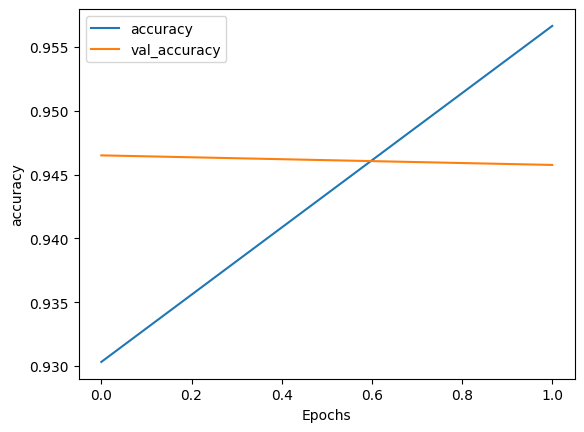

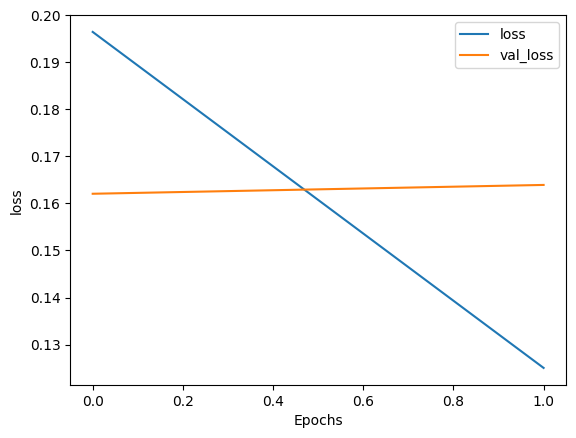

In [12]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_lstm_stance, 'accuracy')
plot_graphs(history_lstm_stance, 'loss')

In [13]:
history_lstm_stance.history

{'loss': [0.19644244015216827, 0.12503769993782043],
 'accuracy': [0.9303200244903564, 0.9566400051116943],
 'val_loss': [0.16205042600631714, 0.16392484307289124],
 'val_accuracy': [0.9465000033378601, 0.9457499980926514]}

In [14]:
model_lstm_stance.evaluate(testing_padded,testing_labels_stance)

196/196 [==============================] - 3s 10ms/step - loss: 0.1489 - accuracy: 0.9467


[0.14894700050354004, 0.9467049837112427]

In [15]:
model_lstm_stance.save("data/Bi_LSTM_stance.h5")

In [16]:
import pickle

# saving
with open('data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
model = tf.keras.models.load_model('data/Bi_LSTM_stance.h5')

def preprocess_text(text):

    max_length = 120
    trunc_type='post'
    padding_type='post'

    # loading
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    text_sequences = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return text_padded

def predict_stance(tweet):
    # Preprocess the tweet text
    preprocessed_tweet = preprocess_text(tweet)
    
    # Make a prediction with the loaded model
    prediction = model.predict(preprocessed_tweet)[0][0]
    
    # Determine the Stance label based on the prediction
    if prediction >= 0.5:
        return 'Believer'
    else:
        return 'Denier'

In [33]:
print(predict_stance("Climate change is real"))
print(predict_stance("Climate change is fake"))

1/1 [==============================] - 0s 38ms/step
Believer
1/1 [==============================] - 0s 42ms/step
Denier


In [19]:
from keras.utils import to_categorical

In [20]:
training_labels_senti = to_categorical(training_labels_senti,num_classes=3)
validation_labels_senti = to_categorical(validation_labels_senti,num_classes=3)
testing_labels_senti = to_categorical(testing_labels_senti,num_classes=3)

In [21]:
# Model Definition with Bi_LSTM Sentiment model
model_lstm_senti = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Set the training parameters
model_lstm_senti.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm_senti.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 64)           640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 120, 128)         66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 751,619
Trainable params: 751,619
Non-tr

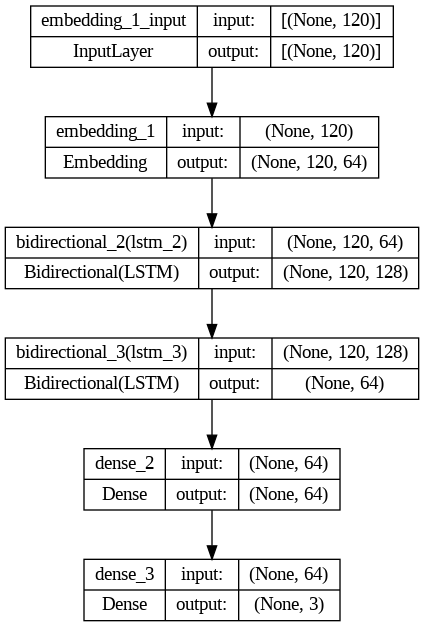

In [46]:
tf.keras.utils.plot_model(model_lstm_senti,show_shapes=True, show_layer_names=True)

In [22]:
NUM_EPOCHS = 10

# Train the model
history_lstm_senti = model_lstm_senti.fit(training_padded, training_labels_senti, epochs=NUM_EPOCHS, validation_data=(validation_padded, validation_labels_senti),callbacks=[callbacks])

Epoch 1/10
1563/1563 [==============================] - 76s 43ms/step - loss: 0.9448 - accuracy: 0.5395 - val_loss: 0.8875 - val_accuracy: 0.5857
Epoch 2/10
1563/1563 [==============================] - 38s 25ms/step - loss: 0.8298 - accuracy: 0.6231 - val_loss: 0.8746 - val_accuracy: 0.5928
Epoch 3/10
1563/1563 [==============================] - 35s 23ms/step - loss: 0.7579 - accuracy: 0.6571 - val_loss: 0.9073 - val_accuracy: 0.5893
Epoch 4/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.6912 - accuracy: 0.6856 - val_loss: 0.9487 - val_accuracy: 0.5913
Epoch 5/10
1563/1563 [==============================] - 35s 22ms/step - loss: 0.6267 - accuracy: 0.7136 - val_loss: 1.0354 - val_accuracy: 0.5807
Epoch 6/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.5705 - accuracy: 0.7391 - val_loss: 1.1677 - val_accuracy: 0.5698
Epoch 7/10
1563/1563 [==============================] - 35s 22ms/step - loss: 0.5187 - accuracy: 0.7608 - val_loss: 1.2910 -

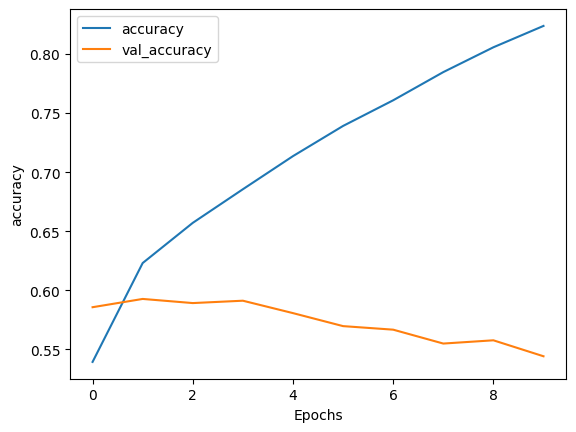

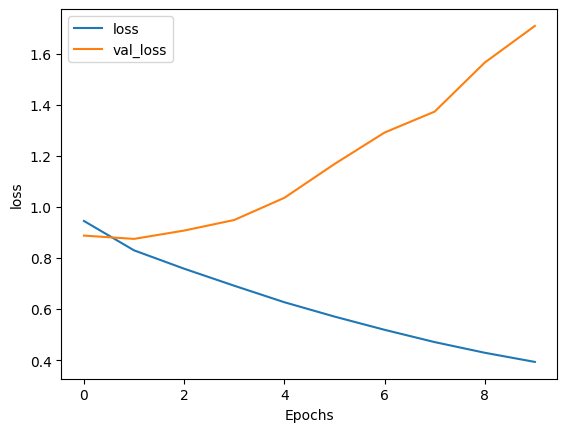

In [23]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_lstm_senti, 'accuracy')
plot_graphs(history_lstm_senti, 'loss')

In [24]:
history_lstm_senti.history

{'loss': [0.9448038935661316,
  0.8298003077507019,
  0.7579121589660645,
  0.691239595413208,
  0.6266904473304749,
  0.5705411434173584,
  0.5187318921089172,
  0.47062188386917114,
  0.42889073491096497,
  0.39300039410591125],
 'accuracy': [0.5394600033760071,
  0.6231200098991394,
  0.6571199893951416,
  0.6855599880218506,
  0.7135800123214722,
  0.7391200065612793,
  0.7608199715614319,
  0.7846599817276001,
  0.8056600093841553,
  0.8237400054931641],
 'val_loss': [0.8875415325164795,
  0.874631404876709,
  0.9072582721710205,
  0.9486758708953857,
  1.0354089736938477,
  1.1676568984985352,
  1.290971279144287,
  1.3728910684585571,
  1.5649034976959229,
  1.7083914279937744],
 'val_accuracy': [0.5857499837875366,
  0.5927500128746033,
  0.5892500281333923,
  0.5912500023841858,
  0.5807499885559082,
  0.5697500109672546,
  0.5667499899864197,
  0.5550000071525574,
  0.5577499866485596,
  0.5442500114440918]}

In [25]:
model_lstm_senti.evaluate(testing_padded,testing_labels_senti)

196/196 [==============================] - 4s 14ms/step - loss: 1.6752 - accuracy: 0.5523


[1.6751943826675415, 0.5522578358650208]

In [26]:
model_lstm_senti.save("data/Bi_LSTM_senti.h5")

In [27]:
prediction = model_lstm_senti.predict(testing_padded)[0]

196/196 [==============================] - 3s 8ms/step


In [28]:
prediction

array([0.00118565, 0.9797263 , 0.01908796], dtype=float32)

In [29]:
label = np.argmax(prediction)

In [30]:
label

1

In [41]:
model = tf.keras.models.load_model('data/Bi_LSTM_senti.h5')

def preprocess_text(text):

    max_length = 120
    trunc_type='post'
    padding_type='post'

    # loading
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    text_sequences = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return text_padded

def predict_senti(tweet):
    # Preprocess the tweet text
    preprocessed_tweet = preprocess_text(tweet)

    # Make a prediction with the loaded model
    prediction = model.predict(preprocessed_tweet)[0]
    
    # Determine the sentiment label based on the prediction
    label = np.argmax(prediction)
    if label == 0:
        return ('Neutral',prediction)
    elif label == 1:
        return ('Positive',prediction)
    else:
        return ('Negative',prediction)

In [42]:
print(predict_senti("Climate change is real"))
print(predict_senti("Goverment policy are excellent regarding climate change"))
print(predict_senti("Climate change is a propaganda"))

1/1 [==============================] - 1s 1s/step
('Neutral', array([0.78273255, 0.16363734, 0.05363011], dtype=float32))
1/1 [==============================] - 0s 23ms/step
('Positive', array([0.3144948 , 0.37512574, 0.31037942], dtype=float32))
1/1 [==============================] - 0s 24ms/step
('Negative', array([1.2514104e-04, 6.1241648e-05, 9.9981362e-01], dtype=float32))
